In [1]:
%matplotlib widget
import os
import numpy as np
from sklearn.preprocessing import scale  # Import the scale function for normalizing data
from sklearn.decomposition import PCA  # Import PCA for dimensionality reduction
from umap import UMAP  # Import UMAP for non-linear dimensionality reduction
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import HTML
pio.renderers.default = "notebook"
import ffmpeg

In [2]:
def visualize_multiple_trajectories(trajectories, trajectory_names=None, window_size=10, interval=100, colors=None, time_points=None):
    """
    创建多条3D轨迹的动态可视化，并显示时间信息
    
    参数:
    trajectories: list of numpy arrays, 每个数组shape为(n_points, 3)
    trajectory_names: list of str, 每条轨迹的名称，如果为None则使用默认名称
    window_size: int, 同时显示的时间点数量
    interval: int, 动画帧间隔(毫秒)
    colors: list of str, 轨迹颜色列表，如果为None则使用默认颜色
    time_points: array-like, 可选，对应每个点的时间值。如果为None，则使用索引作为时间
    """
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    while len(colors) < len(trajectories):
        colors.extend(colors)
    
    if trajectory_names is None:
        trajectory_names = [f'Trajectory {i+1}' for i in range(len(trajectories))]
    elif len(trajectory_names) < len(trajectories):
        trajectory_names.extend([f'Trajectory {i+1}' for i in range(len(trajectory_names), len(trajectories))])
    
    # 如果没有提供时间点，使用索引作为时间
    if time_points is None:
        time_points = np.arange(len(trajectories[0]))
    
    all_points = np.vstack(trajectories)
    
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    z_min, z_max = all_points[:, 2].min(), all_points[:, 2].max()
    
    x_range = [x_min, x_max]
    y_range = [y_min, y_max]
    z_range = [z_min, z_max]

    layout = dict(
        scene=dict(
            xaxis=dict(
                range=x_range,
                title='X',
                autorange=False,
                showgrid=True,
                showspikes=False,
                showline=True,
                zeroline=False,
                showbackground=True,
                backgroundcolor='white',
                showticklabels=False,
                tickmode='array',
                tickvals=np.linspace(x_min, x_max, 5),
                ticktext=[''] * 5,
                tickwidth=2,
                linewidth=2,
                linecolor='black',
                gridcolor='lightgray',
                gridwidth=1,
            ),
            yaxis=dict(
                range=y_range,
                title='Y',
                autorange=False,
                showgrid=True,
                showspikes=False,
                showline=True,
                zeroline=False,
                showbackground=True,
                backgroundcolor='white',
                showticklabels=False,
                tickmode='array',
                tickvals=np.linspace(y_min, y_max, 5),
                ticktext=[''] * 5,
                tickwidth=2,
                linewidth=2,
                linecolor='black',
                gridcolor='lightgray',
                gridwidth=1,
            ),
            zaxis=dict(
                range=z_range,
                title='Z',
                autorange=False,
                showgrid=True,
                showspikes=False,
                showline=True,
                zeroline=False,
                showbackground=True,
                backgroundcolor='white',
                showticklabels=False,
                tickmode='array',
                tickvals=np.linspace(z_min, z_max, 5),
                ticktext=[''] * 5,
                tickwidth=2,
                linewidth=2,
                linecolor='black',
                gridcolor='lightgray',
                gridwidth=1,
            ),
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
            aspectmode='cube',
        ),
        width=800,
        height=600,
        showlegend=True,
        title={
            'text': '3D Trajectories Visualization<br>Time: 0',
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        uirevision='constant',
        template="plotly_white",
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    
    fig = go.Figure(layout=layout)
    
    # 添加初始轨迹（显示坐标轴）
    fig.add_trace(go.Scatter3d(
        x=[x_min, x_max],
        y=[y_min, y_max],
        z=[z_min, z_max],
        mode='lines',
        line=dict(width=0, color='rgba(0,0,0,0)'),
        showlegend=False
    ))
    
    # 添加时间滑块
    fig.update_layout(
        sliders=[{
            'currentvalue': {
                'prefix': 'Time: ',
                'visible': True,
                'xanchor': 'right'
            },
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'xanchor': 'left',
            'yanchor': 'top',
            'transition': {'duration': interval},
            'pad': {'b': 10, 't': 50},
            'steps': []
        }]
    )
    
    # 添加实际的轨迹
    for i, traj in enumerate(trajectories):
        fig.add_trace(go.Scatter3d(
            x=[], y=[], z=[],
            mode='lines+markers',
            name=trajectory_names[i],
            line=dict(width=4, color=colors[i]),
            marker=dict(size=3, color=colors[i])
        ))
    
    step = max(1, len(trajectories[0]) // 2000)
    
    # 创建帧
    frames = []
    slider_steps = []
    
    for frame_idx, i in enumerate(range(0, len(trajectories[0]), step)):
        frame_data = []
        current_time = time_points[i]
        
        # 添加隐藏的轨迹以保持坐标轴显示
        frame_data.append(
            go.Scatter3d(
                x=[x_min, x_max],
                y=[y_min, y_max],
                z=[z_min, z_max],
                mode='lines',
                line=dict(width=0, color='rgba(0,0,0,0)'),
                showlegend=False
            )
        )
        
        for traj_idx, (traj, color) in enumerate(zip(trajectories, colors)):
            start_idx = max(0, i - window_size + 1)
            current_slice = traj[start_idx:i+1:step]
            
            frame_data.append(
                go.Scatter3d(
                    x=current_slice[:, 0],
                    y=current_slice[:, 1],
                    z=current_slice[:, 2],
                    mode='lines+markers',
                    line=dict(width=4, color=color),
                    marker=dict(size=3, color=color),
                    name=trajectory_names[traj_idx]
                )
            )
        
        frame = go.Frame(
            data=frame_data,
            name=f'frame{frame_idx}',
            layout=dict(title=f'3D Trajectories Visualization<br>Time: {current_time:.2f}')
        )
        frames.append(frame)
        
        slider_steps.append({
            'args': [[f'frame{frame_idx}'],
                    {'frame': {'duration': interval, 'redraw': True},
                     'mode': 'immediate'}],
            'label': f'{current_time:.2f}',
            'method': 'animate'
        })
    
    fig.frames = frames
    
    # 更新滑块步骤
    fig.layout.sliders[0]['steps'] = slider_steps
    
    # 添加动画控制
    fig.update_layout(
        updatemenus=[
            dict(
                type='buttons',
                showactive=False,
                x=0.1,
                y=0,
                xanchor='right',
                yanchor='top',
                pad=dict(t=0, r=10),
                buttons=[
                    dict(
                        label='Play',
                        method='animate',
                        args=[None, dict(
                            frame=dict(duration=interval, redraw=True),
                            fromcurrent=True,
                            mode='immediate'
                        )]
                    ),
                    dict(
                        label='Pause',
                        method='animate',
                        args=[[None], dict(
                            frame=dict(duration=0, redraw=False),
                            mode='immediate',
                            transition=dict(duration=0)
                        )]
                    )
                ]
            )
        ]
    )
    
    return fig

In [3]:
## 从basic information中得来
gump_umap = np.load('sub_embeds.npy')


## Off the Shelf
start_idx = 0
end_idx = start_idx + 3543

gump_umap_z = stats.zscore(gump_umap, axis=1)
gump_umap_z_Flower = gump_umap_z[:, start_idx:end_idx, :]

In [4]:
trajectories=[np.mean(gump_umap_z_Flower[0:3, :, :], axis=0), np.mean(gump_umap_z_Flower[3:6, :, :], axis=0),np.mean(gump_umap_z_Flower[6:9, :, :], axis=0), 
         np.mean(gump_umap_z_Flower[9:12,:, :], axis=0),np.mean(gump_umap_z_Flower[12:15, :, :], axis=0)]



fig = visualize_multiple_trajectories(
        trajectories=trajectories,
        trajectory_names=['group1', 'group2', 'group3', 'group4', 'group5'],
        window_size=5,
        interval=100
    )

In [5]:
fig.write_html("trajectory_animation.html")

### 显示每个人作为散点的动画

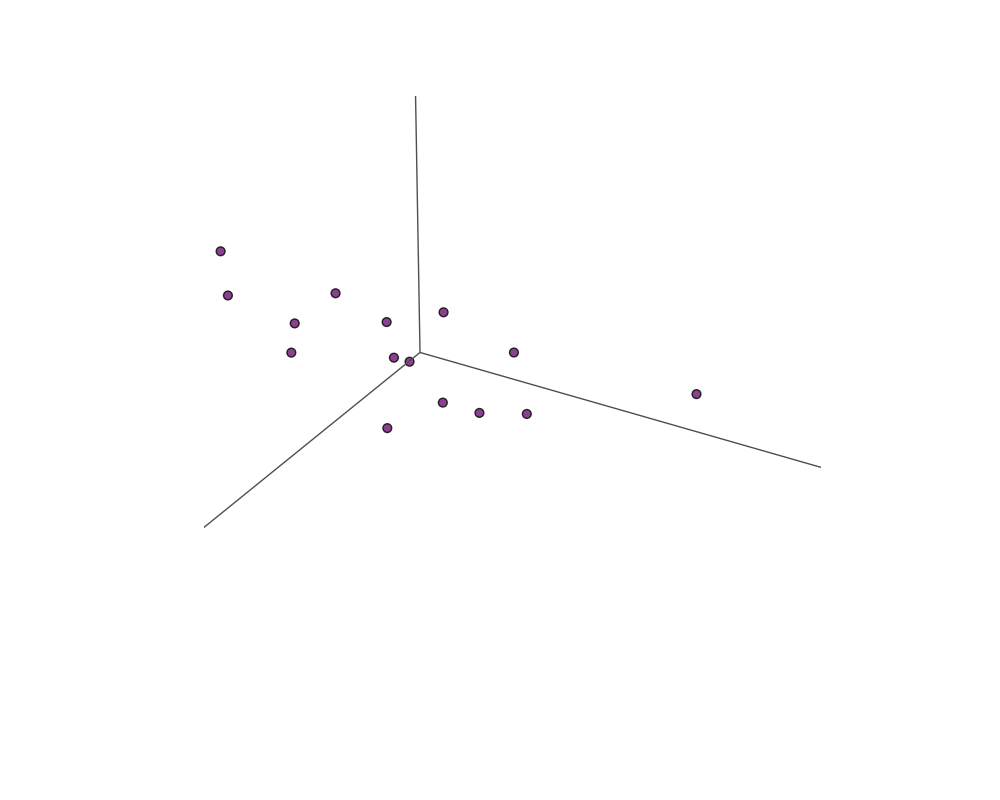

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.animation as animation
from matplotlib.colors import to_rgb


distance_all_z = np.load('distance_all_z.npy')[start_idx:end_idx]
color_degree = 2 * (distance_all_z - np.min(distance_all_z)) / np.ptp(distance_all_z) - 1  

fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot(111, projection='3d')

# 定义两个颜色
color1 = to_rgb('#0a20df')  
color2 = to_rgb('#d10306')  

# 初始化绘制数据点
scat = ax.scatter(gump_umap_z_Flower[:, 0, 0], 
                  gump_umap_z_Flower[:, 0, 1], 
                  gump_umap_z_Flower[:, 0, 2], 
                  c='#383838', marker='o', s=40, alpha=0.8, edgecolors='#000000')
# 计算数据中的最大绝对值，并稍微放大一点（比如1.1倍）
# 这样坐标轴永远刚好比数据长一点点
max_val = np.max(np.abs(gump_umap_z_Flower)) * 1.1

# 使用变量 max_val 替换掉原来的 7
ax.quiver(0, 0, 0, 10, 0, 0, color='#4f4f4f', arrow_length_ratio=0.1, linewidth=1)
ax.quiver(0, 0, 0, 0, -20, 0, color='#4f4f4f', arrow_length_ratio=0.1, linewidth=1)
ax.quiver(0, 0, 0, 0, 0, 30, color='#4f4f4f', arrow_length_ratio=0.1, linewidth=1)

# 隐藏坐标轴和背景
ax.set_axis_off()
ax.set_facecolor('white')

# 颜色插值函数
def interpolate_color(degree, color1, color2):
    return (1 - degree) * np.array(color1) + degree * np.array(color2)

# 更新函数|
def update(frame):
    scat._offsets3d = (gump_umap_z_Flower[:, frame, 0], 
                       gump_umap_z_Flower[:, frame, 1], 
                       gump_umap_z_Flower[:, frame, 2])
    current_color = interpolate_color((color_degree[frame] + 1) / 2, color1, color2)
    scat.set_facecolor(current_color)
    return scat,

# 创建动画
ani = animation.FuncAnimation(fig, update, frames=gump_umap_z_Flower.shape[0], interval=1000, blit=True)

# 修改前
# ani.save('gump_umap_animation.mp4', writer='ffmpeg', dpi=300, bitrate=3000)

# 修改后：文件名改成 .gif，writer改成 pillow
ani.save('gump_umap_animation.gif', writer='pillow', fps=1)

# 或者显示动画
plt.show()